# Sentiment analysis

By Alexis Moraga & Felipe Pérez

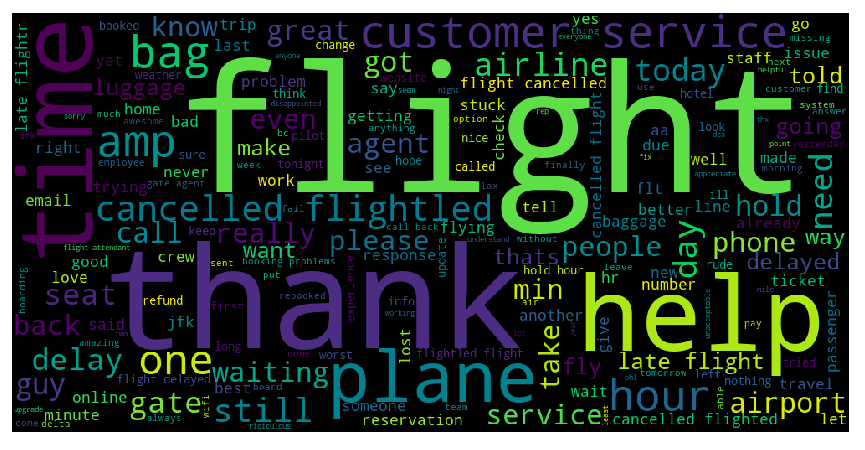

In [1]:
from IPython.display import Image
Image("../input/wordcloud-twitter/wordcloud.png")

## Introduction

## Loading the data

The libraries we will use througout the notebook:

In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

We import the dataset into a dataframe using pandas:

In [3]:
df = pd.read_csv("../input/airline-sentiment/Tweets.csv")

## Data cleansing and feature engineering

Let's havea quick look at the first entries of the dataframe:

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


We can see that there is quite a lot of information about each tweet. We rename the columns of the dataframe:

In [5]:
df.columns = (['id','sent','conf','negreas','reasconf','airline','sentgold','name','negold',
              'retweet_cout','text','tweet_coord','time','locat','timezone'])

Let's check the distribution of the sentiment across the whole dataset:

In [6]:
df['sent'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: sent, dtype: int64

In general, we are interested in distinguishing positive and negative tweets, so we will exclude the tweets 

In [7]:
df = df[df['sent'] != 'neutral']

The dataset is skewed towards negative sentiment, so it is reasonable to expect better accuracy when recognizing negative tweets. We proceed now to clean the text data. We will use regular expressions to get rid of unwanted characters and restrict to the English alphabet. We also lowercase the text:

In [8]:
import re
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

We can check that the text now only has characters from the English alphabet:

In [9]:
df['text'].head()

1    virginamerica plus youve added commercials to ...
3    virginamerica its really aggressive to blast o...
4    virginamerica and its a really big bad thing a...
5    virginamerica seriously would pay 30 a flight ...
6    virginamerica yes nearly every time i fly vx t...
Name: text, dtype: object

We will do some basic statistics now with the words of the dataset. The total number of words in the dataset is:

In [10]:
words = []
for w in df['text']:
    words = words + w.split()
len(words)


212083

From these, the number of unique words is

In [11]:
unique_words = set(words)
len(unique_words)

14001

Let's see what are the most common words found in the dataset:

In [12]:
from collections import Counter as ct
counter = ct(words) 
counter.most_common(10)

[('to', 6977),
 ('the', 5076),
 ('i', 4202),
 ('a', 3693),
 ('united', 3410),
 ('you', 3382),
 ('for', 3378),
 ('flight', 3274),
 ('and', 3256),
 ('on', 3113)]

We can see that from the ten most common words, 8 are [stop words](https://en.wikipedia.org/wiki/Stop_words). In order to improve the accuracy of our model, we will get rid of the stop words in our dataset. For this we will use the nltk module. We have found that some stop words are not in its library, so we manually added them:

In [13]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words = stop_words + ["i'm","us","i've","u","can't"]
print("The number of stop words is " + str(len(stop_words)))

The number of stop words is 184


We will apply the same transformation to the stop words so they have the same format as our dataset:

In [14]:
stop_words = [(lambda x: re.sub('[^a-zA-z0-9\s]','',x))(x) for x in stop_words]
stop_words[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'youre']

We can see now which words of the dataset, excluding stop words, are the most common:

In [15]:
filtered_words = [w for w in words if w not in stop_words]
filtered_counter = ct(filtered_words) 
filtered_counter.most_common(10)

[('united', 3410),
 ('flight', 3274),
 ('usairways', 2650),
 ('americanair', 2458),
 ('southwestair', 1784),
 ('jetblue', 1639),
 ('get', 1096),
 ('cancelled', 958),
 ('thanks', 918),
 ('service', 902)]

From the 10 most common words, most of them are names of airlines. We make a list of the names of the airlines so we can exclude them from the dataset. Otherwise, if an airline had mostly negative reviews, the model would be biased to predict negative whenever it sees the name of that airline in a test review.

In [16]:
airlines = ['united','usairways','americanair','southwestair','jetblue','virginamerica']
filtered_words = [w for w in filtered_words if w not in airlines]
filtered_counter = ct(filtered_words) 
filtered_counter.most_common(10)

[('flight', 3274),
 ('get', 1096),
 ('cancelled', 958),
 ('thanks', 918),
 ('service', 902),
 ('customer', 717),
 ('help', 692),
 ('time', 678),
 ('hours', 651),
 ('hold', 614)]

We can now generate a nice graphic showing the most common words:

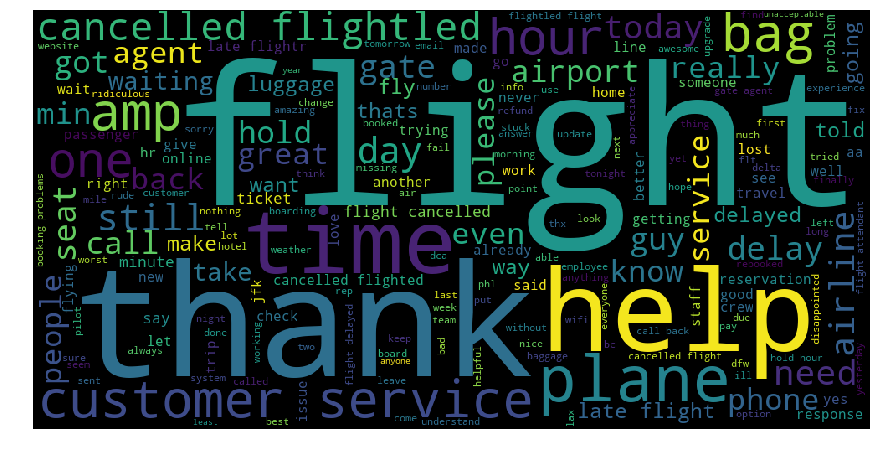

In [17]:
from wordcloud import WordCloud
unique_string=(" ").join(filtered_words)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Finally, we apply the same filters to the dataframe containing each tweet:

In [18]:
df['text'] = df['text'].apply(lambda x: (" ").join([w for w in x.split() if w not in (stop_words+airlines)]))
df['text'].head()

1              plus added commercials experience tacky
3    really aggressive blast obnoxious entertainmen...
4                                 really big bad thing
5    seriously would pay 30 flight seats playing re...
6        yes nearly every time fly vx ear worm go away
Name: text, dtype: object

## First model: recurrent neural network, LSTM

The first model we will use to learn the dataset is a recurrent neural network, more precisely, a LSTM. This allows to learn information about sequences as if they were time series. The architecture of the network is based on ad hoc arguments and can be adjusted accordingly to the dataset. We will use Keras with Tensorflow backend:

In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


The first step is to tokenize the sentences: we will use the 2000 most common words of the dataset. The number of words to use for each sentence is the maximum number of words on a sentence in the dataset, in this case, 20. Then we pad the sentences of length less than 20 with empty words.

In [20]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['text'].values)
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X)

We build now the neural network: this is a sequential model, with an embedding layer, a dropout layer, a LSTM layer and a dense layer for binary clasification. The embedding layer takes the tokenized model for words and embeds them into a lower dimensional space. By training the network, this forces the embedding layer to send similar meaning words to close points into this lower dimensional space, as opposed to the tokenized model where each word spans its own dimension. The LSTM layer is the key component for the network, as it is able to hold information of the sequence of words, so it can make sense of full sentences. Both the dropout layer and the dropout parameters in the LSTM layer prevent overfitting. Finally, as per usual in the LSTM networks, we use the categorical cross-entropy as a loss function, the adam optimizer and the accuracy as a metric.

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [22]:
embed_dim = 128
lstm_out = 196

rnn = Sequential()
rnn.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
rnn.add(SpatialDropout1D(0.3))
rnn.add(LSTM(lstm_out, dropout=0.3, recurrent_dropout=0.2))
rnn.add(Dense(2,activation='softmax'))
rnn.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(rnn.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 20, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


We convert the sentiment target value to a binary and split the training data into a training and a test batch:

In [23]:
Y = pd.get_dummies(df['sent']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7732, 20) (7732, 2)
(3809, 20) (3809, 2)


We now train the model to 8 epochs, with a batch training size of 32.

In [24]:
batch_size = 32
rnn.fit(X_train, Y_train, epochs = 12, batch_size=batch_size, verbose = 2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/12
 - 14s - loss: 0.3443 - acc: 0.8579
Epoch 2/12
 - 11s - loss: 0.1916 - acc: 0.9255
Epoch 3/12
 - 12s - loss: 0.1479 - acc: 0.9415
Epoch 4/12
 - 12s - loss: 0.1264 - acc: 0.9494
Epoch 5/12
 - 12s - loss: 0.1036 - acc: 0.9586
Epoch 6/12
 - 12s - loss: 0.0813 - acc: 0.9679
Epoch 7/12
 - 11s - loss: 0.0697 - acc: 0.9732
Epoch 8/12
 - 11s - loss: 0.0583 - acc: 0.9770
Epoch 9/12
 - 12s - loss: 0.0466 - acc: 0.9815
Epoch 10/12
 - 11s - loss: 0.0473 - acc: 0.9806
Epoch 11/12
 - 11s - loss: 0.0385 - acc: 0.9856
Epoch 12/12
 - 11s - loss: 0.0304 - acc: 0.9886


We can see that the model achieves high accuracy in the training model. We can use the test set to see if the model is indeed learning general patterns or is just overfitting:

In [25]:
score,acc = rnn.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.60
acc: 0.90


We can see that the accuracy of the prediction is fairly high. We can check the accuracy for each category (positive/negative sentiment):

In [26]:
score,acc = rnn.evaluate(X_test[pd.DataFrame(Y_test)[0] == 1], Y_test[pd.DataFrame(Y_test)[0] == 1], 
                           verbose = 2, batch_size = batch_size)
print("score negative sentiment: %.2f" % (score))
print("accuracy negative sentiment: %.2f" % (acc))

score,acc = rnn.evaluate(X_test[pd.DataFrame(Y_test)[0] == 0], Y_test[pd.DataFrame(Y_test)[0] == 0], 
                           verbose = 2, batch_size = batch_size)
print("score positive sentiment: %.2f" % (score))
print("accuracy positive sentiment: %.2f" % (acc))

score negative sentiment: 0.34
accuracy negative sentiment: 0.93
score positive sentiment: 1.64
accuracy positive sentiment: 0.76


As expected, the accuracy of the predictions for positively reviewed tweets is lower than for negatively reviwed tweets. This is due to the fact that the training set had a majority of negatively revied tweets, so it is better trained to recognize them than positively reviewed tweets. Finally, we can test the model by predicting the sentiment of tweets written by ourselves. Note that we have to apply the same tokenization and padding process as we did with the training dataset.

In [27]:
tweet = ['The flight got delayed by 3 hours']
tweet = tokenizer.texts_to_sequences(tweet)
tweet = pad_sequences(tweet, maxlen=20, value=0)
sentiment = rnn.predict(tweet,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif(np.argmax(sentiment) == 1):
    print("positive")

negative


## Second approach: word2vec

Now we include a second model that we use to predict the sentiment of the tweets: [word2vec](https://en.wikipedia.org/wiki/Word2vec). The idea is to construct a neural network which is capable of embed the vocabulary used throughout the dataset in a way so that near points represent words with similar meaning in this context. Even though we do not achieve better results, we still include this model as it might prove valuable in situations where the vocabulary is bigger. For this we will use the `gensim` library. We import the library and modules used:

In [28]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

/opt/conda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


Now we define a tokenizer function using gensim:

In [29]:
def token_tweet(row,column_name):
    return gensim.utils.simple_preprocess(str(row[column_name]).encode('utf-8'))

Now we put together all the sentences from all tweets in a list:

In [30]:
documents=[]
for i,row in df.iterrows():
    documents.append(token_tweet(row,"text"))

We set up the gensim word2vec model:

In [31]:
dim_emb = 32
model = gensim.models.Word2Vec(size=dim_emb, window=3, min_count=2, sg=1, workers=10)
model.build_vocab(documents)
model.train(sentences=documents, total_examples=len(documents), epochs=20)

(1763656, 2100780)

The hyperparameters can be tunned using cross validation. We can see how the gensim model can group words according to their similarity:

In [32]:
model.wv.most_similar(positive="terrible", topn=5)

[('horrendous', 0.8647062182426453),
 ('costumer', 0.8170256018638611),
 ('dumped', 0.8126283884048462),
 ('deplorable', 0.8117707371711731),
 ('disgusted', 0.8006442785263062)]

In [33]:
model.wv.most_similar(positive="awesome", topn=5)

[('fantastic', 0.8065752387046814),
 ('rock', 0.7781083583831787),
 ('shout', 0.754643976688385),
 ('wonderful', 0.7427456378936768),
 ('amazing', 0.7406046390533447)]

Now we pass the resulting gensim model as an embedding layer to keras. The parameters of this model are not trainable, as they were already trained by the gensim word2vec model.

In [34]:
vocab=model.wv.vocab
embedding_matrix= np.zeros((len(vocab),dim_emb))

for i,word in enumerate(vocab):
    embedding_matrix[i]=model.wv[word]

maxlen=X.shape[1]


embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                            output_dim=embedding_matrix.shape[1], 
                            input_length=maxlen,
                            weights=[embedding_matrix], 
                            trainable=False, 
                            name='embedding_layer')

Now we build the sequential model in the same way we did in the previous section:

In [35]:
model2=Sequential()
model2.add(embedding_layer)
model2.add(SpatialDropout1D(0.4))
model2.add(LSTM(196, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(2,activation='softmax'))
model2.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 20, 32)            160608    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 20, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               179536    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 394       
Total params: 340,538
Trainable params: 179,930
Non-trainable params: 160,608
_________________________________________________________________
None


And finally we train the model:

In [36]:
batch_size = 32
model2.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 2)

Epoch 1/7
 - 12s - loss: 0.4817 - acc: 0.7963
Epoch 2/7
 - 10s - loss: 0.4605 - acc: 0.8051
Epoch 3/7
 - 10s - loss: 0.4522 - acc: 0.8095
Epoch 4/7
 - 10s - loss: 0.4464 - acc: 0.8108
Epoch 5/7
 - 10s - loss: 0.4446 - acc: 0.8139
Epoch 6/7
 - 10s - loss: 0.4407 - acc: 0.8154
Epoch 7/7
 - 10s - loss: 0.4351 - acc: 0.8156


Its accuracy on the test set is a little lower than the previous model. This is due to the fact that we did not put a lot of work on the optimization of the hyperparameters of the model.

In [37]:
score,acc = model2.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.41
acc: 0.83


## Final remarks

In this notebook we checked two models for implementing a sentiment analysis algorithm. The pure lstm model achieved very high accuracy, while the one using word2vec achieved lower accuracy but provided us with a model which is capable of outputting words related to the input word. This is a very valuable tool that can be used in several different problems. We expect to achieve higher scores when the parameters are further optimized. 

Some sources used for this kernel are [here](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/) and [here](https://www.kaggle.com/ngyptr/lstm-sentiment-analysis-keras).